In [ ]:
# Install required libraries
!pip install -Uqq ipdb
!pip install huggingface_hub

In [2]:
# import relevant packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# read in the training data

df = pd.read_csv('train.csv')
df.head(5)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


# Training Data

In [4]:
# get the column types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [5]:
# We can see that the 'Close' and 'Volume' columns are of type object as there are commas
# separating thousands positions. Read in the data again setting this parameter to get the
# columns as float/int

df = pd.read_csv('train.csv', thousands=',')

# Convert the date to datetime object
df['Date'] = pd.to_datetime(df['Date'])

df.head(5)

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,7380500
1,2012-01-04,331.27,333.87,329.08,666.45,5749400
2,2012-01-05,329.83,330.75,326.89,657.21,6590300
3,2012-01-06,328.34,328.77,323.68,648.24,5405900
4,2012-01-09,322.04,322.29,309.46,620.76,11688800


In [6]:
# Check the column types again. Now all numerical columns are float or int
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB


In [7]:
# Check how many rows are there in the data
df.shape

(1258, 6)

In [9]:
# Extract the month, year and quarter from the date
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

df.head(5)

,Date,Open,High,Low,Close,Volume,Month,Year,Quarter
0,2012-01-03,325.25,332.83,324.97,663.59,7380500,1,2012,1
1,2012-01-04,331.27,333.87,329.08,666.45,5749400,1,2012,1
2,2012-01-05,329.83,330.75,326.89,657.21,6590300,1,2012,1
3,2012-01-06,328.34,328.77,323.68,648.24,5405900,1,2012,1
4,2012-01-09,322.04,322.29,309.46,620.76,11688800,1,2012,1


# Exploratory Data Analysis

<Axes: xlabel='Date', ylabel='Open'>

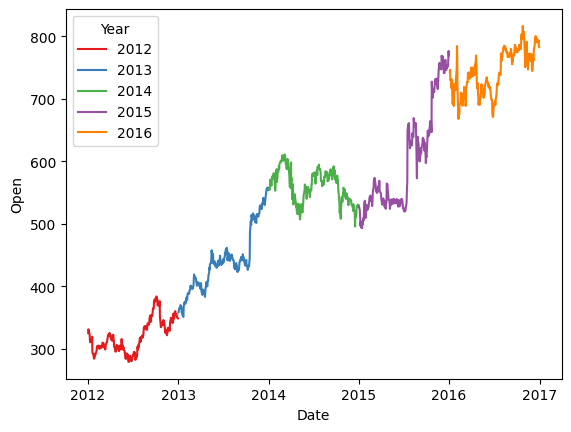

In [10]:
sns.lineplot(data=df, x='Date',y='Open',hue='Year', palette='Set1')

<Axes: xlabel='Date', ylabel='Close'>

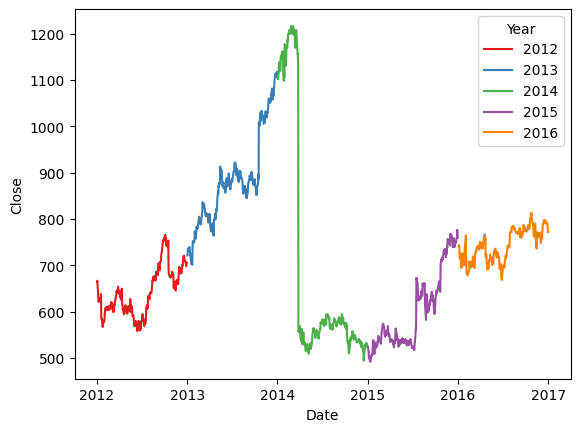

In [11]:
sns.lineplot(data=df, x='Date',y='Close',hue='Year', palette='Set1')

<Axes: xlabel='Date', ylabel='High'>

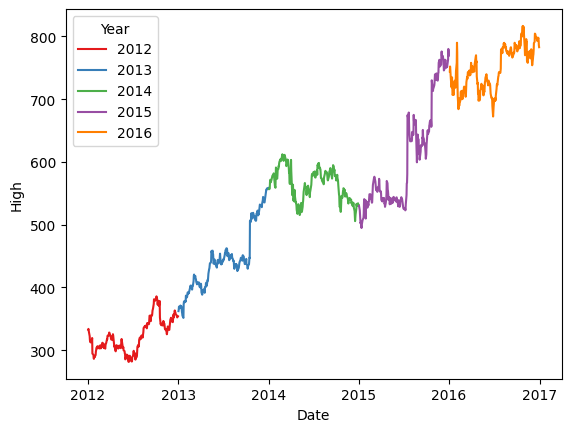

In [12]:
sns.lineplot(data=df, x='Date',y='High',hue='Year', palette='Set1')

<Axes: xlabel='Date', ylabel='Low'>

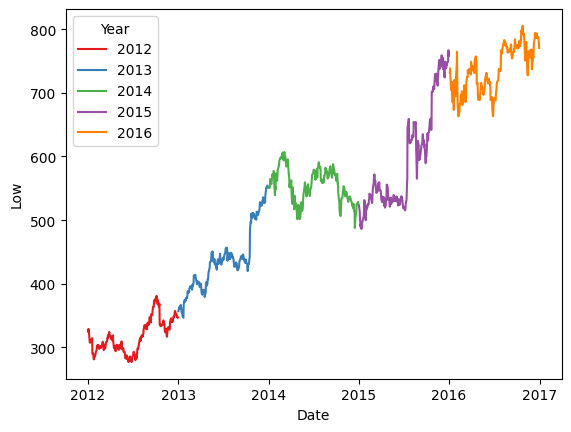

In [13]:
sns.lineplot(data=df, x='Date',y='Low',hue='Year', palette='Set1')

<Axes: xlabel='Year', ylabel='Open'>

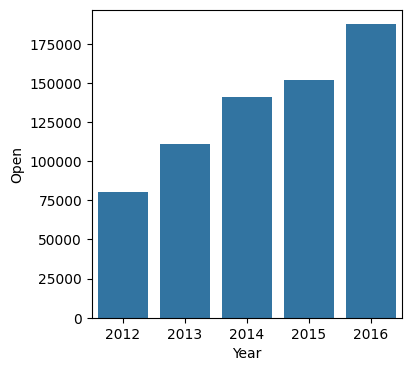

In [14]:
df_year = df[['Open','Year']].groupby(by='Year').sum().reset_index()
plt.figure(figsize=((4,4)))
sns.barplot(data=df_year, x='Year', y='Open')

<Axes: xlabel='Month', ylabel='Open'>

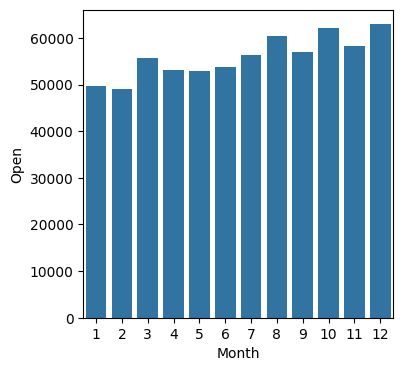

In [15]:
df_month = df[['Open','Month']].groupby(by='Month').sum().reset_index()
plt.figure(figsize=((4,4)))
sns.barplot(data=df_month, x='Month', y='Open')

<Axes: xlabel='Quarter', ylabel='Open'>

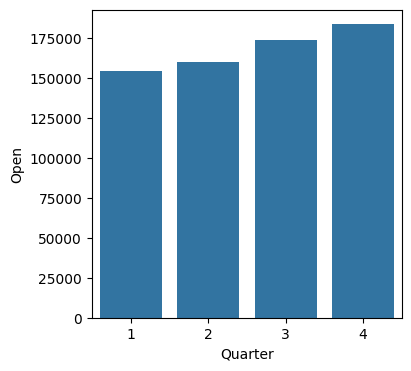

In [16]:
df_quarter = df[['Open','Quarter']].groupby(by='Quarter').sum().reset_index()
plt.figure(figsize=((4,4)))
sns.barplot(data=df_quarter, x='Quarter', y='Open')

# Train an LSTM model

In [17]:
# Log in to your Hugging Face account
# Get your API token here https://huggingface.co/settings/token
from huggingface_hub import notebook_login

notebook_login()

In [18]:
# Preparing the training data
from sklearn.preprocessing import MinMaxScaler

df_train = df.drop(columns=['Date', 'Low', 'Close', 'Volume', 'Month', 'Year', 'Quarter'])
# Scale the data
scaler_open = MinMaxScaler()
scaler_high = MinMaxScaler()
# df_train[['Open', 'High']] = scaler.fit_transform(df_train[['Open', 'High']])
df_train['Open'] = scaler_open.fit_transform(df_train['Open'].values.reshape(-1,1))
df_train['High'] = scaler_high.fit_transform(df_train['High'].values.reshape(-1,1))
df_train_open = df_train[['Open']]
df_train_high = df_train[['High']]
df_train_open.head()

,Open
0,0.085814
1,0.097012
2,0.094334
3,0.091562
4,0.079842


In [19]:
# define the model
import torch.nn as nn
import torch
from huggingface_hub import PyTorchModelHubMixin

class LSTM(nn.Module, PyTorchModelHubMixin):

  def __init__(self, config: dict):
    super(LSTM, self).__init__()
    self.hidden_dim = config['hidden_dim']
    self.num_layers = config['num_layers']

    self.lstm = nn.LSTM(config['input_dim'], config['hidden_dim'],
                        config['num_layers'], batch_first=True)
    self.fc = nn.Linear(config['hidden_dim'], config['output_dim'])

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn, cn) = self.lstm(x) #, (h0.detach(), c0.detach()))
    out =  self.fc(out[:, -1, :])
    return out

In [20]:
import numpy as np

def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_eval = data[train_set_size:,:-1]
    y_eval = data[train_set_size:,-1,:]

    return [x_train, y_train, x_eval, y_eval]

lookback = 20 # choose sequence length
x_train, y_train, x_eval, y_eval = split_data(df_train_open, lookback)
display(x_train.shape)
display(y_train.shape)
display(x_eval.shape)
display(y_eval.shape)

(990, 19, 1)

(990, 1)

(248, 19, 1)

(248, 1)

In [ ]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_eval = torch.from_numpy(x_eval).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_eval = torch.from_numpy(y_eval).type(torch.Tensor)

In [23]:
import time
import ipdb

config = {'input_dim': 1,
          'hidden_dim': 64,
          'num_layers': 5,
          'output_dim': 1,
          'num_epochs': 500}

model = LSTM(config=config)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(config['num_epochs'])
start_time = time.time()
lstm = []
for t in range(config['num_epochs']):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    if(t%100 == 0):
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

# save locally
model.save_pretrained("lstm-stock-price-predictor", config=config)

# push to the hub
model.push_to_hub("lstm-stock-price-predictor", config=config)

Epoch  0 MSE:  0.16300484538078308
Epoch  100 MSE:  0.0021997601725161076
Epoch  200 MSE:  0.0005859489319846034
Epoch  300 MSE:  0.0010998251382261515
Epoch  400 MSE:  0.0003122244088444859
Training time: 504.8805453777313


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/608k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/suryaR-15/lstm-stock-price-predictor/commit/ae979a5fde2c41b7749f3b9f62f0a64b1037fe1c', commit_message='Push model using huggingface_hub.', commit_description='', oid='ae979a5fde2c41b7749f3b9f62f0a64b1037fe1c', pr_url=None, pr_revision=None, pr_num=None)

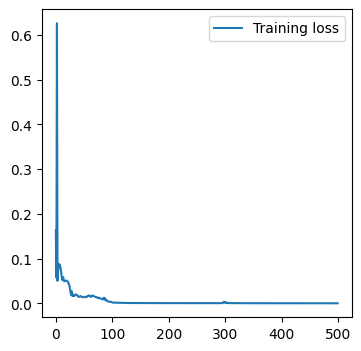

In [24]:
plt.figure(figsize=(4, 4))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

# Evaluate the model

In [25]:
# run the model on the evaluation data

import math
from sklearn.metrics import mean_squared_error

y_eval_pred = model(x_eval)

# invert the scaling
inverse_scaler = MinMaxScaler()
y_inversed_pred = scaler_open.inverse_transform(y_eval_pred.detach())
y_inversed = scaler_open.inverse_transform(y_eval.detach())

testScore = np.sqrt(mean_squared_error(y_inversed, y_inversed_pred))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 11.52 RMSE


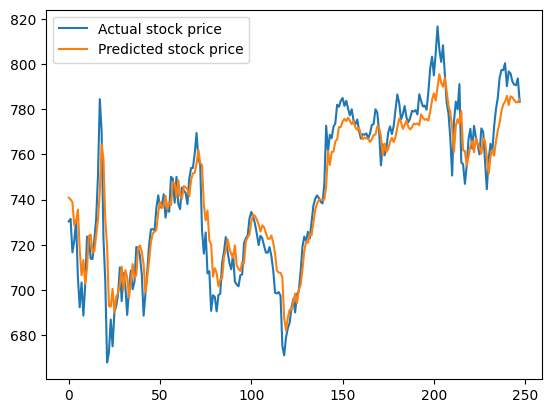

In [26]:
# plot baseline and predictions
plt.plot(y_inversed, label='Actual stock price')
plt.plot(y_inversed_pred, label='Predicted stock price')
plt.legend()
plt.show()

# Inference



In [27]:
# read in the test data
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_test.head(5)

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [28]:
model.eval()

LSTM(
  (lstm): LSTM(1, 64, num_layers=5, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [29]:
# Extract the actual closing prices from the test data
actual_prices = df_test['Open'].values

In [30]:
# Concatenate the training and test data along the 'Open' column
total_dataset = pd.concat((df_train['Open'], df_test['Open']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(df_test) - lookback:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler_open.transform(model_inputs)

In [31]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the lookback index
for x in range(lookback, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-lookback:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test = torch.from_numpy(x_test).type(torch.Tensor)

# Generate price predictions using the LSTM model
predicted_prices = model(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler_open.inverse_transform(predicted_prices.detach())

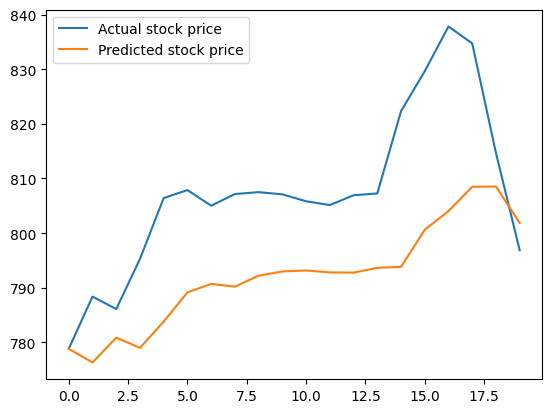

In [32]:
# plot baseline and predictions
plt.plot(actual_prices, label='Actual stock price')
plt.plot(predicted_prices, label='Predicted stock price')
plt.legend()
plt.show()